In [20]:
# !pip install -q shap gplearn openpyxl xgboost

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
print(sys.executable)


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.neighbors import NearestNeighbors



D:\Anaconda\Anaconda3\python.exe


In [21]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [7]:

import sys

!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

!{sys.executable} -m pip install TorchSisso

Looking in indexes: https://download.pytorch.org/whl/cpu


In [22]:
COLOR_ORANGE = "#FF7F00"
COLOR_BLUE   = "#20AAED"
COLOR_BLUE2  = "#20AAED"
COLOR_BLUE3  = "#20AAED"
COLOR_GRAY   = "#444444"

mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["axes.linewidth"] = 1.2
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 13
mpl.rcParams["xtick.direction"] = "out"
mpl.rcParams["ytick.direction"] = "out"
mpl.rcParams["xtick.major.size"] = 4
mpl.rcParams["ytick.major.size"] = 4
mpl.rcParams["savefig.dpi"] = 900
mpl.rcParams["figure.dpi"] = 240

OUTDIR = "outputs_figs"
os.makedirs(OUTDIR, exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print(f"Saved: {path}")


In [14]:
DATA_PATH = r'C:\Users\weili\Desktop\Database.xlsx'
SHEET_NAME = 0

df_raw = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
print("Raw shape:", df_raw.shape)
display(df_raw.head())

COL_M = "M_label"
COL_X = "X_label"
COL_T = "T_label"
COL_N = "n"
COL_Y = "Wf_cal" 

def normalize_T(x):
    if pd.isna(x): return x
    s = str(x).strip().upper().replace("*","").replace("-","")
    if s in ["F","F2","FT","FTERM"]: return "F"
    if s in ["O","O2","OT","OTERM"]: return "O"
    if s in ["OH","OHT","OHTERM"]: return "OH"
    return str(x).strip()

df = df_raw.copy()
df[COL_T] = df[COL_T].apply(normalize_T)
df[COL_Y] = pd.to_numeric(df[COL_Y], errors="coerce")

key_cols = [COL_M, COL_X, COL_T, COL_N, COL_Y]
before = len(df)
df = df.dropna(subset=key_cols).reset_index(drop=True)
after = len(df)

print(f"After dropping missing keys: {before} -> {after}")
print("Unique M:", df[COL_M].nunique(), "Unique X:", df[COL_X].nunique(),
      "Unique T:", df[COL_T].nunique(), "n range:", df[COL_N].min(), "-", df[COL_N].max())


Raw shape: (197, 24)


,name,n,M_label,X_label,T_label,a,d,VBM_PBE,CBM_PBE,Eg_PBE,...,En_M,En_X,En_T,r_M,r_X,r_T,Ip_M,Ip_X,Ip_T,Wf_cal
0,Cr2CF2,1,Cr,C,F,2.697,5.174,-3.339,-3.339,0.000,...,1.66,2.55,3.98,42.7,59.6,64,6.7660,11.2603,17.42,4.300603
1,Hf2CF2,1,Hf,C,F,3.157,5.482,-1.219,-1.219,0.000,...,1.30,2.55,3.98,82.9,59.6,64,6.8250,11.2603,17.42,3.630109
2,Mo2CF2,1,Mo,C,F,2.885,5.680,-2.895,-2.895,0.000,...,2.16,2.55,3.98,70.2,59.6,64,7.0942,11.2603,17.42,5.867242
3,Nb2CF2,1,Nb,C,F,2.939,5.852,-2.861,-2.861,0.000,...,1.60,2.55,3.98,74.7,59.6,64,6.7588,11.2603,17.42,4.342834
4,Sc2CF2,1,Sc,C,F,3.216,5.020,-2.549,-1.716,0.833,...,1.36,2.55,3.98,53.9,59.6,64,6.5614,11.2603,17.42,4.515988


After dropping missing keys: 197 -> 197
Unique M: 11 Unique X: 2 Unique T: 3 n range: 1 - 3


In [15]:
#cell3 
exclude_cols = set([COL_Y, COL_M, COL_X, COL_T])
cat_cols = [COL_M, COL_X, COL_T]

num_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
if COL_N not in num_cols:
    num_cols = [COL_N] + num_cols
num_cols = list(dict.fromkeys(num_cols))

print("Categorical columns:", cat_cols)
print("Numeric feature columns (count={}):".format(len(num_cols)))
print(num_cols)

X = df[cat_cols + num_cols].copy()
y = df[COL_Y].values


Categorical columns: ['M_label', 'X_label', 'T_label']
Numeric feature columns (count=19):
['n', 'a', 'd', 'VBM_PBE', 'CBM_PBE', 'Eg_PBE', 'VBM_PBE0', 'CBM_PBE0', 'Eg_PBE0', 'IsGap', 'En_M', 'En_X', 'En_T', 'r_M', 'r_X', 'r_T', 'Ip_M', 'Ip_X', 'Ip_T']


In [16]:
#cell4 
RANDOM_STATE = 42

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

models = {
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(
        n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1, min_samples_leaf=2
    ),
    "MLP": MLPRegressor(
        hidden_layer_sizes=(64,32,16),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=5000,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=50,
        random_state=RANDOM_STATE
    )
}


In [17]:
#Cell 6 
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rows = []
for name, model in models.items():
    pipe_cv = Pipeline([("prep", preprocess), ("model", model)])
    scores = cross_val_score(pipe_cv, X, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
    mae_scores = -scores
    cv_rows.append([name, mae_scores.mean(), mae_scores.std()])

cv_df = pd.DataFrame(cv_rows, columns=["Model","MAE_CV_mean(eV)","MAE_CV_std(eV)"]).sort_values("MAE_CV_mean(eV)")
display(cv_df)


,Model,MAE_CV_mean(eV),MAE_CV_std(eV)
1,RandomForest,0.335951,0.054427
0,Ridge,0.452236,0.063382
2,MLP,0.507776,0.064590


Saved: outputs_figs\parity_Ridge_Parity.png


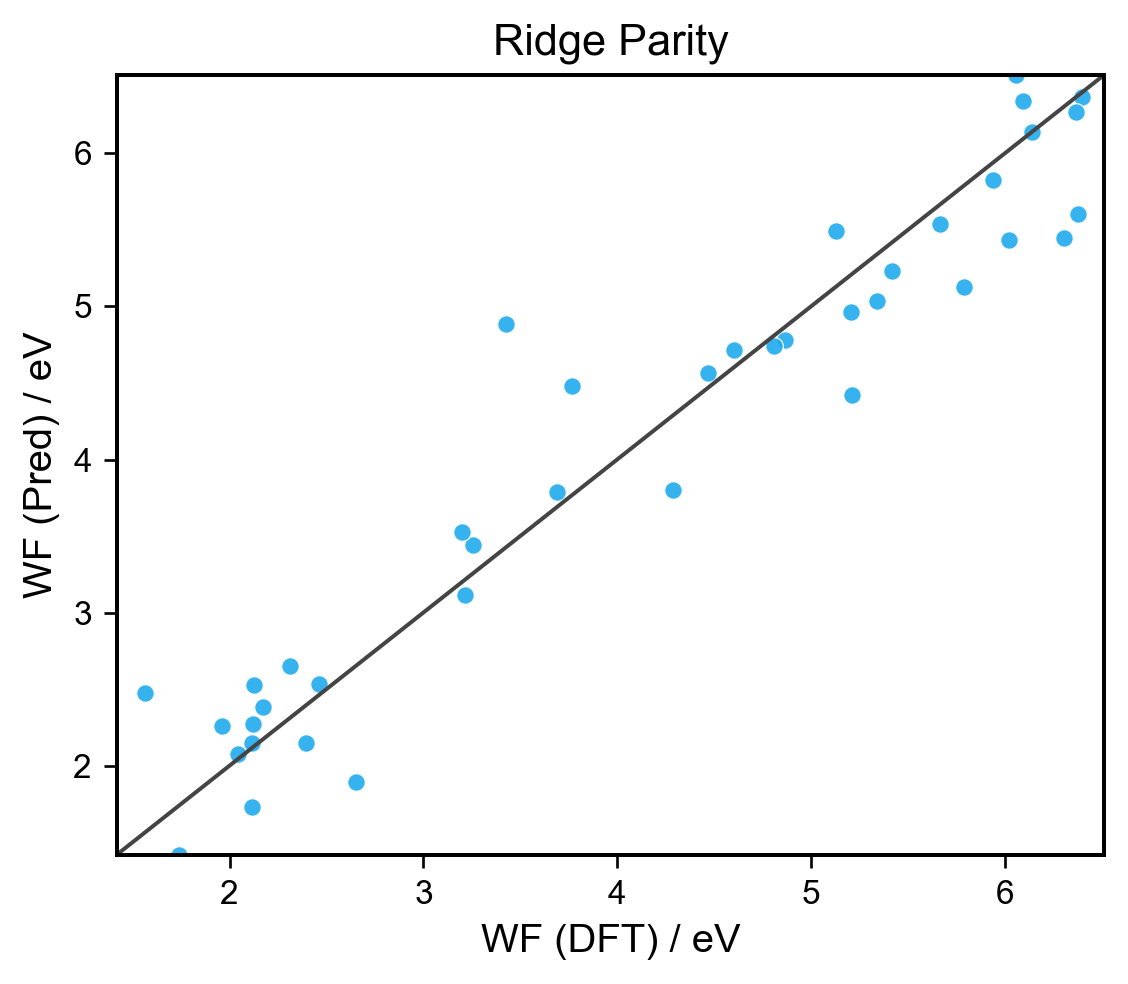

Saved: outputs_figs\residual_Ridge_Residuals.png


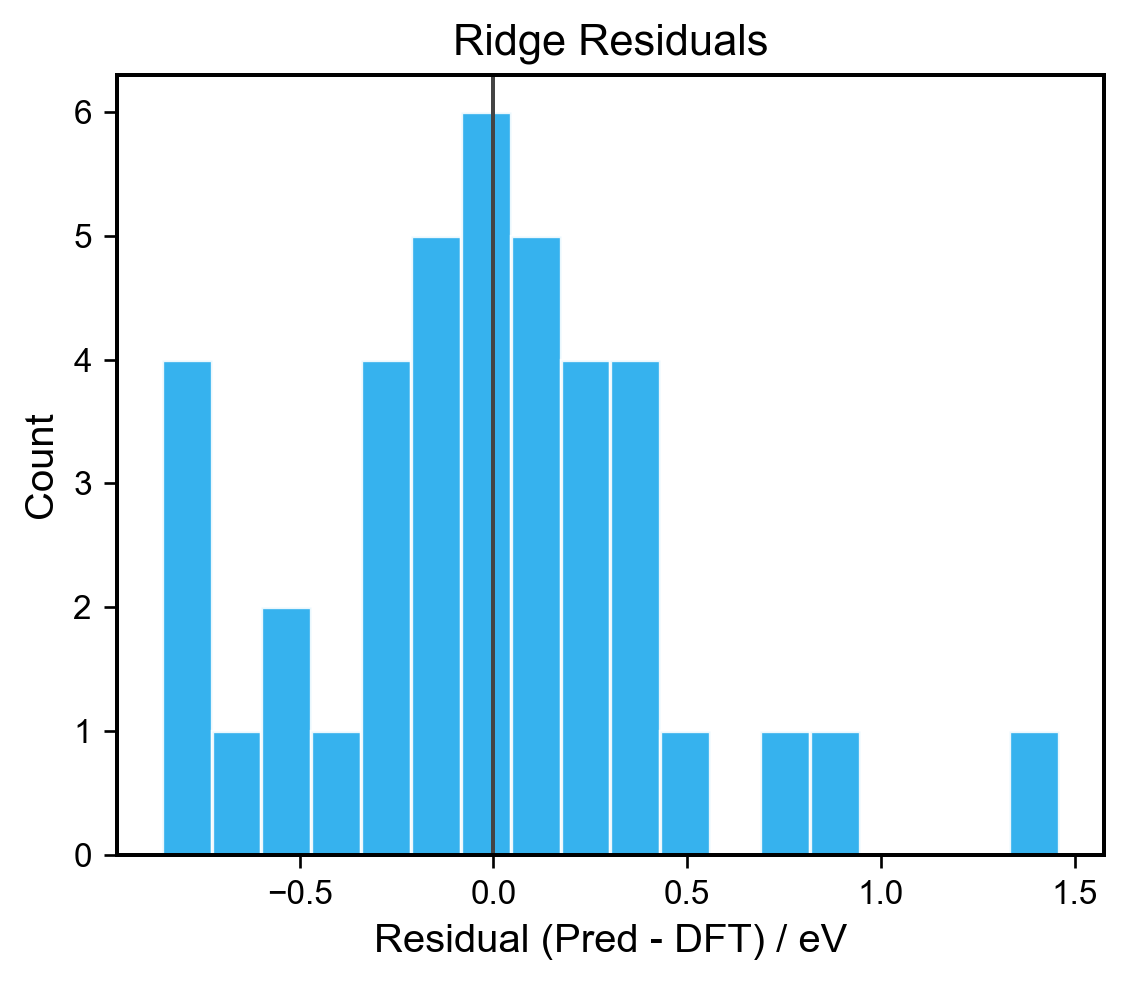

Saved: outputs_figs\parity_RandomForest_Parity.png


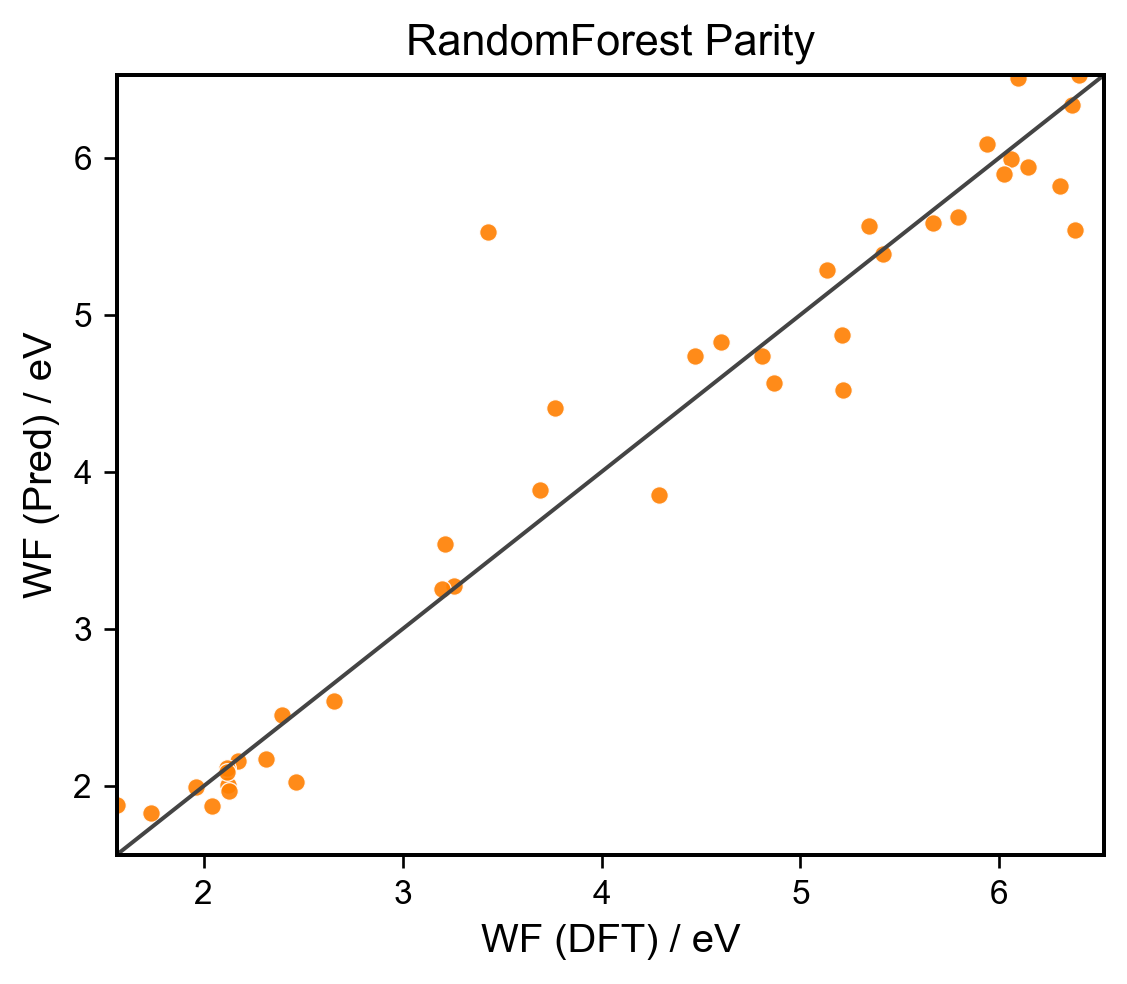

Saved: outputs_figs\residual_RandomForest_Residuals.png


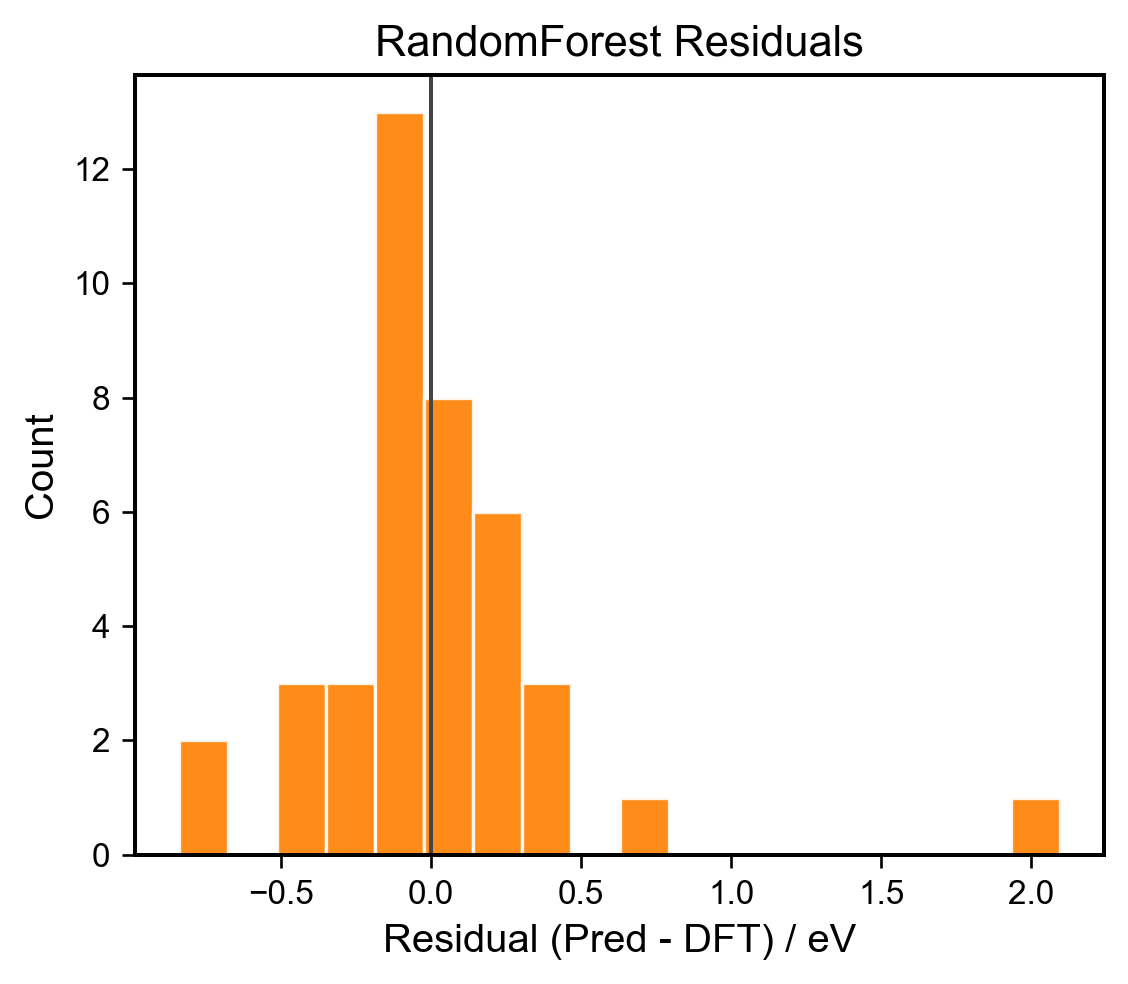

Saved: outputs_figs\parity_MLP_Parity.png


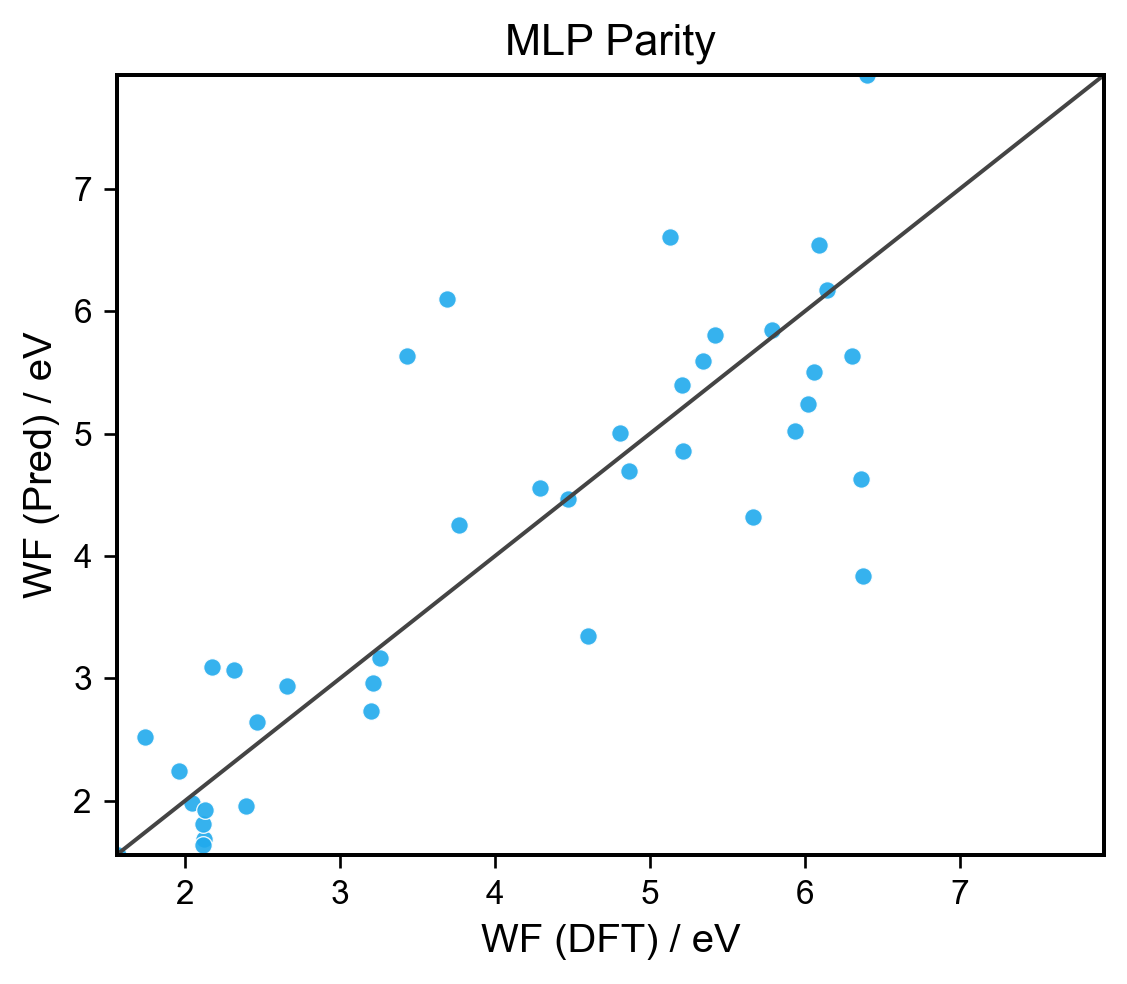

Saved: outputs_figs\residual_MLP_Residuals.png


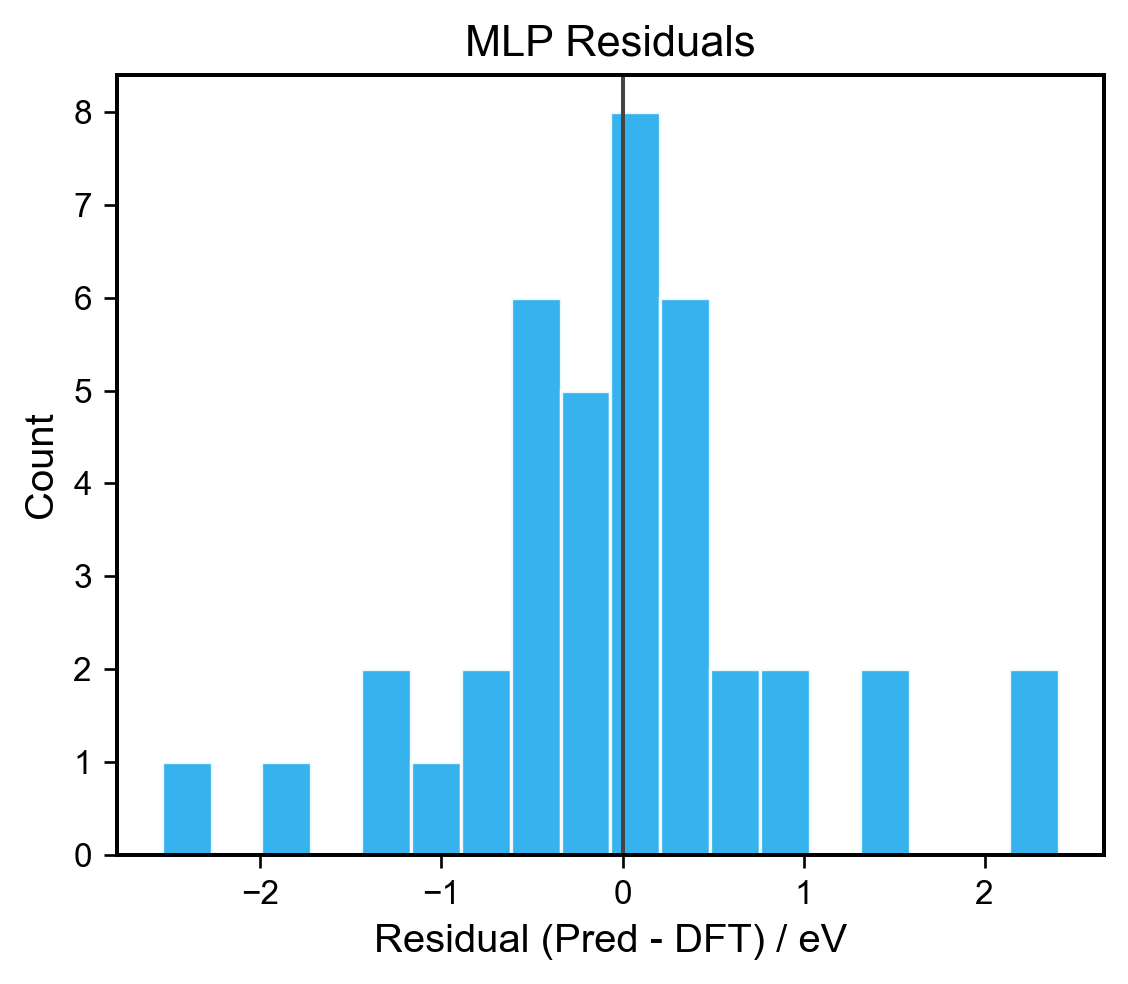

In [23]:
#cell 7 
def parity_plot(y_true, y_pred, title, color):
    plt.figure(figsize=(4.8, 4.2))
    plt.scatter(y_true, y_pred, s=28, alpha=0.9, edgecolor="white", linewidth=0.4, color=color)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, color=COLOR_GRAY, linewidth=1.2)
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("WF (DFT) / eV")
    plt.ylabel("WF (Pred) / eV")
    plt.title(title)
    savefig(os.path.join(OUTDIR, f"parity_{title.replace(' ','_')}.png"))
    plt.show()

def residual_plot(y_true, y_pred, title, color):
    res = y_pred - y_true
    plt.figure(figsize=(4.8, 4.2))
    plt.hist(res, bins=18, color=color, alpha=0.9, edgecolor="white")
    plt.axvline(0, color=COLOR_GRAY, linewidth=1.2)
    plt.xlabel("Residual (Pred - DFT) / eV")
    plt.ylabel("Count")
    plt.title(title)
    savefig(os.path.join(OUTDIR, f"residual_{title.replace(' ','_')}.png"))
    plt.show()

for name, pipe in fitted.items():
    y_pred = pipe.predict(X_test)
    color = COLOR_ORANGE if name == "RandomForest" else COLOR_BLUE
    parity_plot(y_test, y_pred, f"{name} Parity", color)
    residual_plot(y_test, y_pred, f"{name} Residuals", color)


In [40]:
#cell 7 
# === Export CSV for Origin: parity & residual raw data ===
import os
import pandas as pd
import numpy as np

EXPORT_DIR = os.path.join(OUTDIR, "origin_csv")
os.makedirs(EXPORT_DIR, exist_ok=True)

all_rows = []

for name, pipe in fitted.items():
    y_pred = pipe.predict(X_test)
    y_true = y_test
    residual = y_pred - y_true

    df_out = pd.DataFrame({
        "Model": name,
        "WF_true_DFT_eV": y_true,
        "WF_pred_eV": y_pred,
        "Residual_pred_minus_true_eV": residual,
        "AbsResidual_eV": np.abs(residual),
    })

   
    file_single = os.path.join(EXPORT_DIR, f"parity_residual_{name}.csv")
    df_out.to_csv(file_single, index=False, encoding="utf-8-sig")
    print("Saved:", file_single)

    all_rows.append(df_out)


df_all = pd.concat(all_rows, ignore_index=True)
file_all = os.path.join(EXPORT_DIR, "parity_residual_ALL_models.csv")
df_all.to_csv(file_all, index=False, encoding="utf-8-sig")
print("Saved:", file_all)

display(df_all.head(10))
# === Optional: export y=x reference line for parity plot ===
min_v = float(min(df_all["WF_true_DFT_eV"].min(), df_all["WF_pred_eV"].min()))
max_v = float(max(df_all["WF_true_DFT_eV"].max(), df_all["WF_pred_eV"].max()))

ref = pd.DataFrame({
    "x": [min_v, max_v],
    "y": [min_v, max_v]
})

ref_path = os.path.join(EXPORT_DIR, "parity_reference_y_equals_x.csv")
ref.to_csv(ref_path, index=False, encoding="utf-8-sig")
print("Saved:", ref_path)
display(ref)
# === Optional: export binned histogram data for residuals (counts per bin) ===
bins = 18  

for name in df_all["Model"].unique():
    d = df_all[df_all["Model"] == name]["Residual_pred_minus_true_eV"].values
    counts, edges = np.histogram(d, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])

    hist_df = pd.DataFrame({
        "BinCenter_eV": centers,
        "Count": counts
    })

    hist_path = os.path.join(EXPORT_DIR, f"residual_hist_{name}_bins{bins}.csv")
    hist_df.to_csv(hist_path, index=False, encoding="utf-8-sig")
    print("Saved:", hist_path)

display(hist_df.head())



Saved: outputs_figs\origin_csv\parity_residual_Ridge.csv
Saved: outputs_figs\origin_csv\parity_residual_RandomForest.csv
Saved: outputs_figs\origin_csv\parity_residual_MLP.csv
Saved: outputs_figs\origin_csv\parity_residual_ALL_models.csv


,Model,WF_true_DFT_eV,WF_pred_eV,Residual_pred_minus_true_eV,AbsResidual_eV
0,Ridge,4.287109,3.812016,-0.475093,0.475093
1,Ridge,6.398743,6.361007,-0.037736,0.037736
2,Ridge,4.865341,4.778956,-0.086385,0.086385
3,Ridge,3.214800,3.127742,-0.087057,0.087057
4,Ridge,6.058053,6.485583,0.427530,0.427530
5,Ridge,1.960124,2.258387,0.298263,0.298263
6,Ridge,5.213366,4.427898,-0.785468,0.785468
7,Ridge,2.654117,1.909837,-0.744280,0.744280
8,Ridge,5.417162,5.222896,-0.194267,0.194267
9,Ridge,5.664074,5.537708,-0.126366,0.126366


Saved: outputs_figs\origin_csv\parity_reference_y_equals_x.csv


,x,y
0,1.433775,1.433775
1,7.929237,7.929237


Saved: outputs_figs\origin_csv\residual_hist_Ridge_bins18.csv
Saved: outputs_figs\origin_csv\residual_hist_RandomForest_bins18.csv
Saved: outputs_figs\origin_csv\residual_hist_MLP_bins18.csv


,BinCenter_eV,Count
0,-2.419697,1
1,-2.152901,0
2,-1.886106,0
3,-1.619310,1
4,-1.352514,2


Saved: outputs_figs\shap_top7_mean_abs_excluding_labels.csv
Saved: outputs_figs\shap_top7_mean_abs_excluding_labels.png
Saved: outputs_figs\shap_top7_mean_abs_excluding_labels.tiff


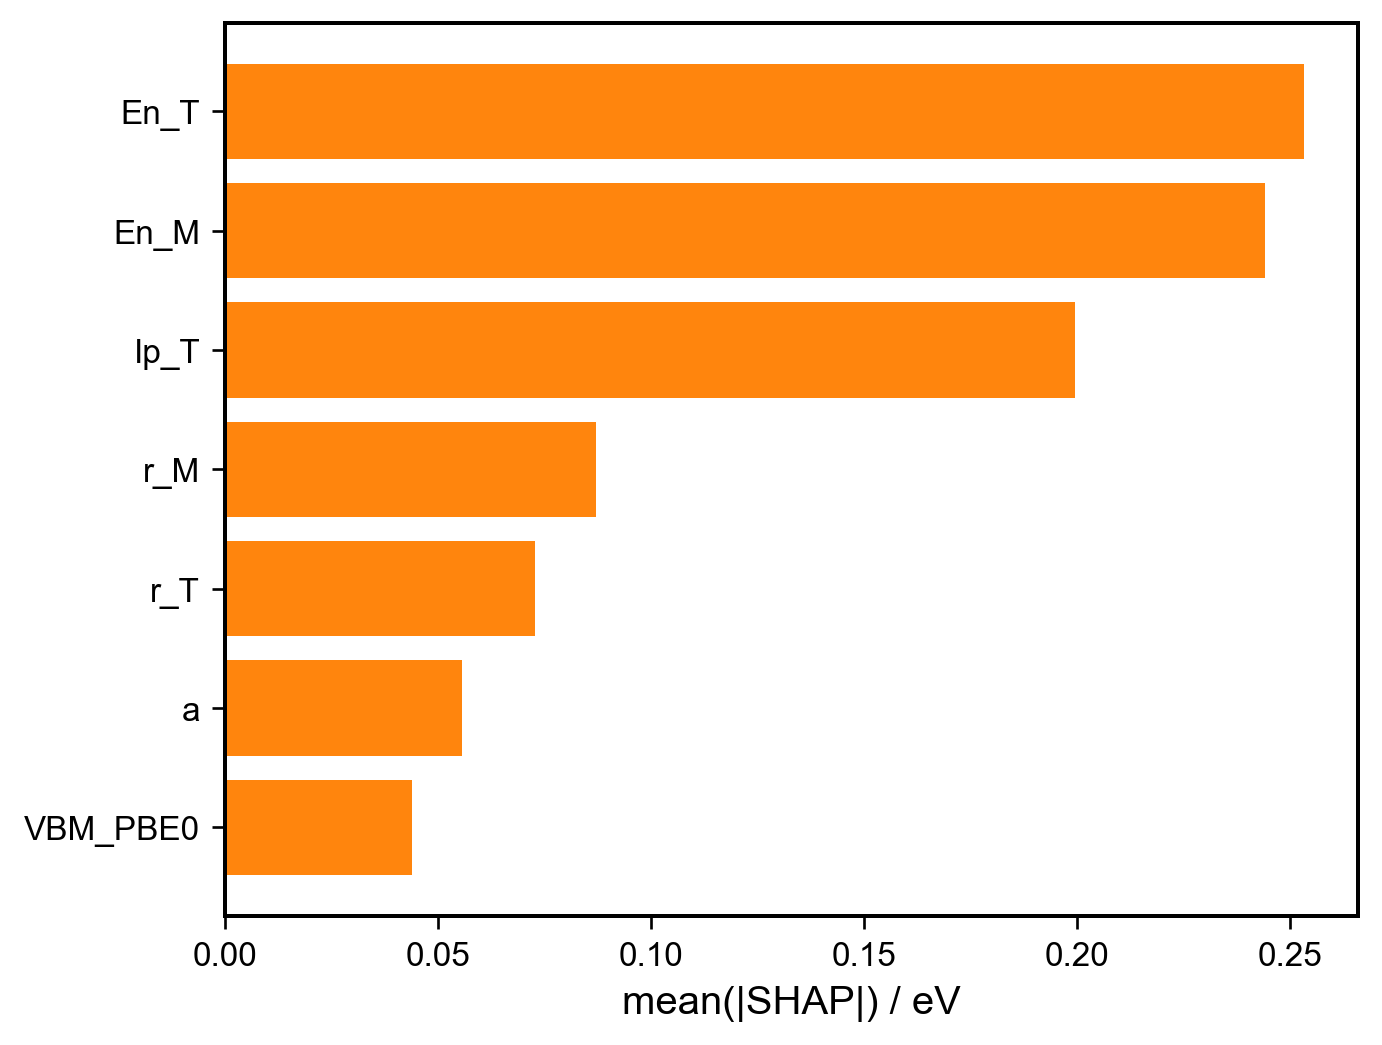

Saved: outputs_figs\shap_summary_top7_excluding_labels_compact.png
Saved: outputs_figs\shap_summary_top7_excluding_labels_compact.tiff


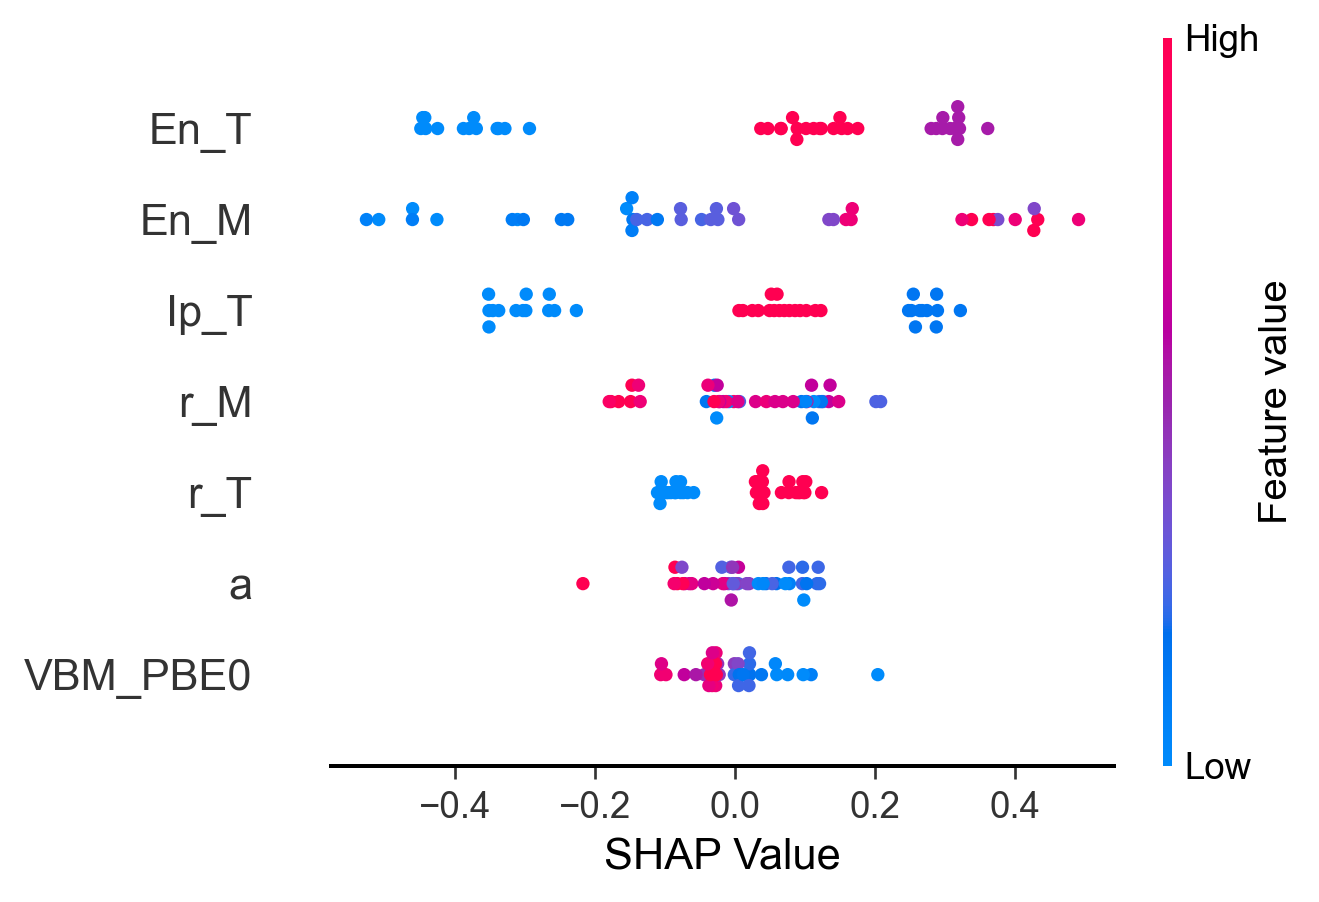

Baseline test MAE (RF): 0.2606 eV
Saved: outputs_figs\perm_top7_mae_increase_excluding_labels.csv
Saved: outputs_figs\perm_top7_mae_increase_excluding_labels.png
Saved: outputs_figs\perm_top7_mae_increase_excluding_labels.tiff


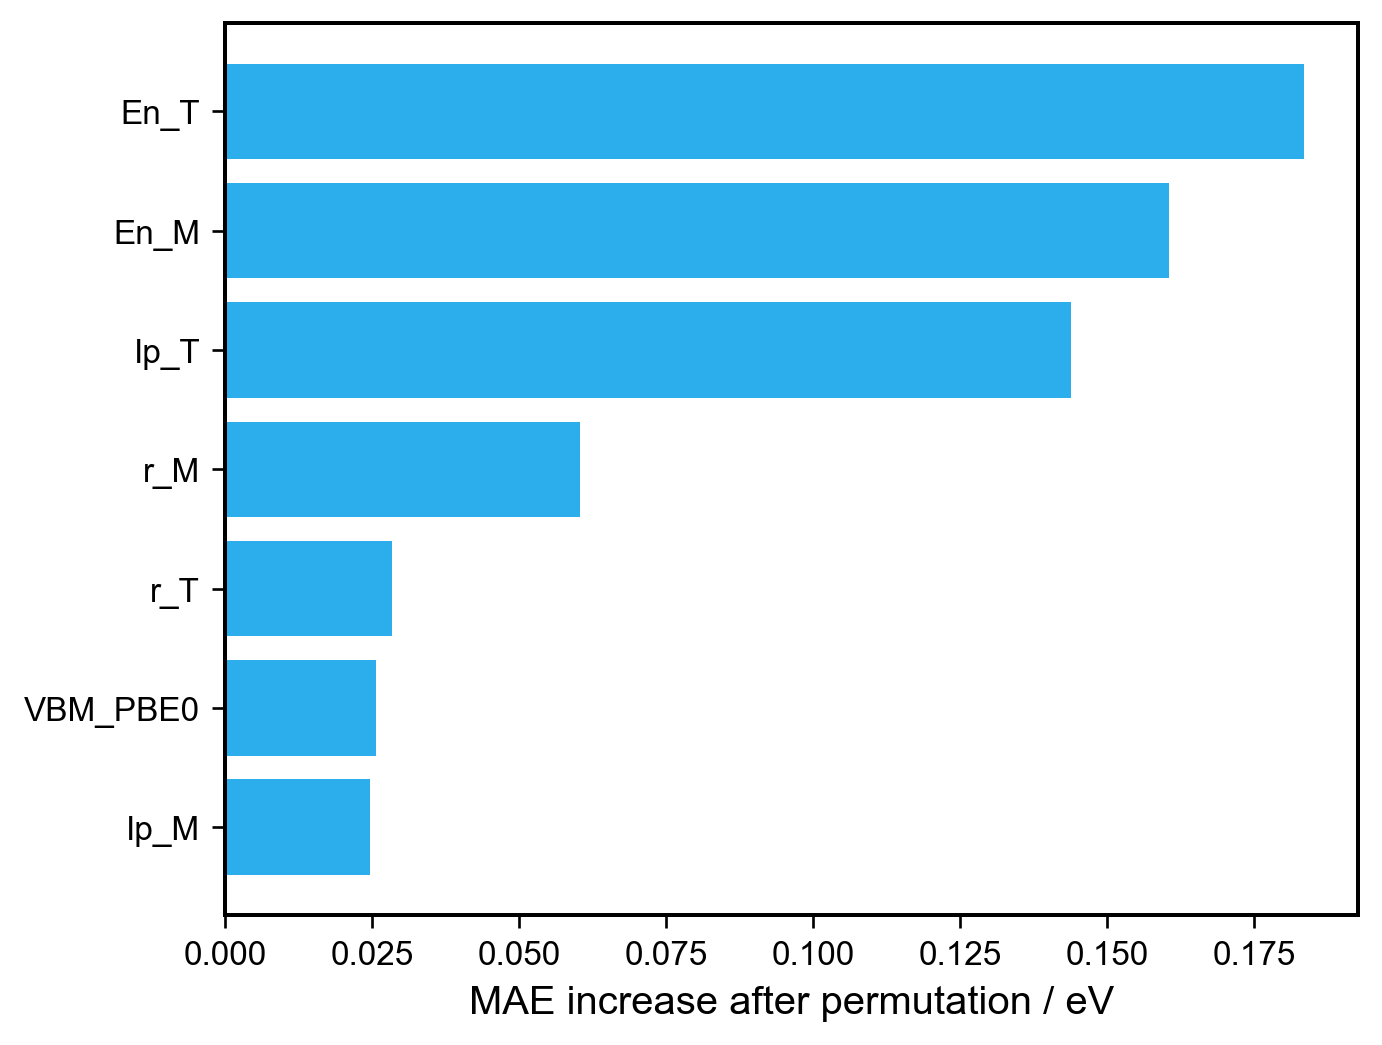


[SHAP Top7 factors (excluded M/X/T labels)]


,feature,mean_abs_shap
1,En_T,0.253411
2,En_M,0.244301
3,Ip_T,0.199618
4,r_M,0.087123
5,r_T,0.072673
6,a,0.055733
7,VBM_PBE0,0.043795



[Permutation Top7 factors (excluded M/X/T labels)]


,feature,mae_increase_mean_eV,mae_increase_std_eV
1,En_T,0.183475,0.033756
2,En_M,0.160578,0.039585
3,Ip_T,0.143766,0.028759
4,r_M,0.060279,0.018003
5,r_T,0.028340,0.016691
6,VBM_PBE0,0.025590,0.010547
7,Ip_M,0.024630,0.009968


In [24]:

# Cell 8 — FINAL: SHAP (Top6, compact beeswarm, TIFF) + Permutation (Top6)

# ---- imports
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

# ---- settings
TOPK = 7
EXCLUDE_LABELS = {"M_label", "X_label", "T_label"}
TIFF_DPI = 900  # 600 or 900 are common for journals

# ---- helper: high-quality TIFF saver
def savefig_tiff(path, dpi=TIFF_DPI):
    plt.tight_layout(pad=0.15)
    try:
        plt.savefig(
            path,
            bbox_inches="tight",
            dpi=dpi,
            format="tiff",
            pil_kwargs={"compression": "tiff_lzw"}  # lossless compression
        )
    except TypeError:
        # fallback for older matplotlib without pil_kwargs
        plt.savefig(path, bbox_inches="tight", dpi=dpi, format="tiff")
    print(f"Saved: {path}")

# ---- 0) pick RF pipeline
rf_pipe = fitted["RandomForest"] if "RandomForest" in fitted else best_model
prep = rf_pipe.named_steps["prep"]
rf_model = rf_pipe.named_steps["model"]

# ---- 1) transform X for SHAP (TreeExplainer expects numeric matrix)
X_train_trans = prep.transform(X_train)
X_test_trans  = prep.transform(X_test)

# convert to dense for SHAP stability
try:
    X_train_trans = X_train_trans.toarray()
except Exception:
    pass
try:
    X_test_trans = X_test_trans.toarray()
except Exception:
    pass

# ---- 2) get encoded feature names aligned with preprocess output
def get_feature_names_from_preprocess(prep, cat_cols, num_cols):
    ohe = prep.named_transformers_["cat"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
    return ohe_names + list(num_cols)

feat_names_encoded = get_feature_names_from_preprocess(prep, cat_cols, num_cols)

# ---- 3) SHAP values (RF)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_trans)  # regression -> (n_samples, n_features)

# mean(|SHAP|) at encoded level (not saved by default; keep if you need debugging)
mean_abs_shap_encoded = np.abs(shap_values).mean(axis=0)

# ---- 4) aggregate one-hot back to raw columns (cat -> sum; num -> itself)
ohe = prep.named_transformers_["cat"]
cat_sizes = [len(cats) for cats in ohe.categories_]  # aligns with cat_cols

group_rows = []
start = 0

# categorical groups (M_label, X_label, T_label)
for col, sz in zip(cat_cols, cat_sizes):
    idx = np.arange(start, start + sz)
    group_rows.append([col, float(mean_abs_shap_encoded[idx].sum())])
    start += sz

# numeric groups
for j, col in enumerate(num_cols):
    idx = start + j
    group_rows.append([col, float(mean_abs_shap_encoded[idx])])

df_shap_grouped = pd.DataFrame(group_rows, columns=["feature", "mean_abs_shap"])
df_shap_grouped = df_shap_grouped.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

# ---- 5) filter out label columns, then take Top7
df_shap_factors = df_shap_grouped[~df_shap_grouped["feature"].isin(EXCLUDE_LABELS)].copy()
df_shap_topk = df_shap_factors.head(TOPK).copy()

# save Top7 SHAP CSV (editable)
csv_shap_topk = os.path.join(OUTDIR, f"shap_top{TOPK}_mean_abs_excluding_labels.csv")
df_shap_topk.to_csv(csv_shap_topk, index=False, encoding="utf-8-sig")
print("Saved:", csv_shap_topk)

# ---- 6) SHAP bar plot (Top7) + TIFF
df_plot = df_shap_topk.iloc[::-1]
plt.figure(figsize=(5.6, 4.2))
plt.barh(df_plot["feature"], df_plot["mean_abs_shap"], color=COLOR_ORANGE, alpha=0.95)
plt.xlabel("mean(|SHAP|) / eV")
plt.title("")  # no title
savefig(os.path.join(OUTDIR, f"shap_top{TOPK}_mean_abs_excluding_labels.png"))
savefig_tiff(os.path.join(OUTDIR, f"shap_top{TOPK}_mean_abs_excluding_labels.tiff"), dpi=TIFF_DPI)
plt.show()

# ---- 7) Compact SHAP beeswarm for Top7 factors only (no title, xlabel=SHAP Value, remove dashed/guide lines) + TIFF
num_start = sum(cat_sizes)  # starting index of numeric part in encoded matrix
topk_feats = df_shap_topk["feature"].tolist()

topk_num_indices, topk_num_names = [], []
for f in topk_feats:
    if f in num_cols:
        j = num_cols.index(f)
        topk_num_indices.append(num_start + j)
        topk_num_names.append(f)

if len(topk_num_indices) > 0:
    shap_vals_sub = shap_values[:, topk_num_indices]
    X_test_sub = X_test_trans[:, topk_num_indices]

    plt.figure(figsize=(5.4, 3.6))  # compact
    shap.summary_plot(
        shap_vals_sub,
        X_test_sub,
        feature_names=topk_num_names,
        show=False,
        max_display=TOPK,
        plot_size=None
    )

    ax = plt.gca()
    ax.set_title("")               # remove title
    ax.set_xlabel("SHAP Value")    # rename x-axis

    # remove dashed/guide lines (incl. common x=0 line even if not dashed)
    for line in list(ax.lines):
        ls = line.get_linestyle()
        xdata = np.array(line.get_xdata(), dtype=float) if line.get_xdata() is not None else np.array([])
        is_zero_vline = (xdata.size >= 2) and np.allclose(xdata, 0.0)
        if ls in ["--", ":", "-."] or is_zero_vline:
            try:
                line.remove()
            except Exception:
                pass

    plt.tight_layout(pad=0.15)

    out_png = os.path.join(OUTDIR, f"shap_summary_top{TOPK}_excluding_labels_compact.png")
    out_tif = os.path.join(OUTDIR, f"shap_summary_top{TOPK}_excluding_labels_compact.tiff")
    plt.savefig(out_png, bbox_inches="tight")
    print("Saved:", out_png)
    savefig_tiff(out_tif, dpi=TIFF_DPI)
    plt.show()
else:
    print("Warning: Top factors contain no numeric descriptors; beeswarm skipped.")

# ---- 8) Permutation Importance (RF pipeline, test set, MAE increase)
baseline_pred = rf_pipe.predict(X_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(f"Baseline test MAE (RF): {baseline_mae:.4f} eV")

perm = permutation_importance(
    rf_pipe, X_test, y_test,
    scoring="neg_mean_absolute_error",
    n_repeats=30,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

df_perm = pd.DataFrame({
    "feature": X_test.columns,
    "mae_increase_mean_eV": perm.importances_mean,  # MAE increase
    "mae_increase_std_eV": perm.importances_std
}).sort_values("mae_increase_mean_eV", ascending=False).reset_index(drop=True)

# exclude label columns, then take Top7
df_perm_factors = df_perm[~df_perm["feature"].isin(EXCLUDE_LABELS)].copy()
df_perm_topk = df_perm_factors.head(TOPK).copy()

# save Top7 Permutation CSV (editable)
csv_perm_topk = os.path.join(OUTDIR, f"perm_top{TOPK}_mae_increase_excluding_labels.csv")
df_perm_topk.to_csv(csv_perm_topk, index=False, encoding="utf-8-sig")
print("Saved:", csv_perm_topk)

# ---- 9) Permutation Top7 plot + TIFF
df_plot2 = df_perm_topk.iloc[::-1]
plt.figure(figsize=(5.6, 4.2))
plt.barh(df_plot2["feature"], df_plot2["mae_increase_mean_eV"], color=COLOR_BLUE, alpha=0.95)
plt.xlabel("MAE increase after permutation / eV")
plt.title("")  # no title
savefig(os.path.join(OUTDIR, f"perm_top{TOPK}_mae_increase_excluding_labels.png"))
savefig_tiff(os.path.join(OUTDIR, f"perm_top{TOPK}_mae_increase_excluding_labels.tiff"), dpi=TIFF_DPI)
plt.show()

# ---- 10) Print Top7 tables (for manuscript copy-paste)
print(f"\n[SHAP Top{TOPK} factors (excluded M/X/T labels)]")
display(df_shap_topk)

print(f"\n[Permutation Top{TOPK} factors (excluded M/X/T labels)]")
display(df_perm_topk)


In [26]:
import pandas as pd
import numpy as np
import warnings


try:
    import torch
except ImportError:
    raise ImportError("未检测到 PyTorch。请先运行 '!pip install torch' 进行安装。")

try:
   
    from TorchSisso import SissoModel
except ImportError:
    try:
        from torchsisso import SissoModel
    except ImportError:
        print("正在尝试自动安装 TorchSisso...")
        import sys
        import subprocess
        subprocess.check_call()
        from TorchSisso import SissoModel

print(f"PyTorch version: {torch.__version__}")
print("TorchSisso 导入成功！")

PyTorch version: 2.8.0+cpu
TorchSisso 导入成功！


In [25]:
%pip install -U typing_extensions


Note: you may need to restart the kernel to use updated packages.


In [26]:
import sys
!{sys.executable} -m pip install -U --force-reinstall --no-cache-dir typing_extensions


     ---------------------------------------- 44.6/44.6 kB ? eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0


In [27]:
!pip install TorchSisso

In [28]:

# Cell10 


from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor


rf_lomo = RandomForestRegressor(
    n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1, min_samples_leaf=2
)
rf_pipe_lomo = Pipeline([("prep", preprocess), ("model", rf_lomo)])

Ms = sorted(df[COL_M].unique())
loo_rows = []
perM_pred_records = []

for m in Ms:
    idx_test = (df[COL_M] == m).values
    X_train_m = X.loc[~idx_test].copy()
    y_train_m = y[~idx_test]
    X_test_m  = X.loc[idx_test].copy()
    y_test_m  = y[idx_test]


    if len(y_test_m) < 2:
        continue

    pipe = clone(rf_pipe_lomo)
    pipe.fit(X_train_m, y_train_m)
    y_pred_m = pipe.predict(X_test_m)

    mae = mean_absolute_error(y_test_m, y_pred_m)
    rmse = mean_squared_error(y_test_m, y_pred_m, squared=False)
    r2 = r2_score(y_test_m, y_pred_m) if len(y_test_m) >= 3 else np.nan

    loo_rows.append([m, len(y_test_m), mae, rmse, r2])

    tmp = X_test_m.copy()
    tmp["WF_true"] = y_test_m
    tmp["WF_pred"] = y_pred_m
    tmp["M_left_out"] = m
    perM_pred_records.append(tmp)

loo_df = pd.DataFrame(
    loo_rows, columns=["M_left_out", "N_test", "MAE(eV)", "RMSE(eV)", "R2"]
).sort_values("MAE(eV)")

display(loo_df)

print(
    "LOMO MAE mean±std:",
    loo_df["MAE(eV)"].mean(), "±", loo_df["MAE(eV)"].std()
)


weighted_mae = np.average(loo_df["MAE(eV)"].values, weights=loo_df["N_test"].values)
print("LOMO MAE weighted by N_test:", weighted_mae)

loo_df.to_csv(os.path.join(OUTDIR, "LOMO_metrics_by_M.csv"), index=False, encoding="utf-8-sig")
loo_df.to_excel(os.path.join(OUTDIR, "LOMO_metrics_by_M.xlsx"), index=False)
print("Saved: LOMO_metrics_by_M.csv / .xlsx")



,M_left_out,N_test,MAE(eV),RMSE(eV),R2
6,Ti,18,0.178124,0.232313,0.977176
5,Ta,18,0.269287,0.316389,0.928028
7,V,17,0.293649,0.340136,0.969146
10,Zr,18,0.351122,0.394764,0.873133
8,W,18,0.395611,0.535645,0.899426
1,Hf,18,0.416911,0.467658,0.795368
3,Nb,18,0.440935,0.577291,0.844907
2,Mo,18,0.459526,0.583111,0.911872
0,Cr,18,0.492764,0.706231,0.870174
9,Y,18,0.571024,0.818696,0.739382


LOMO MAE mean±std: 0.4094545942442687 ± 0.13328838531761078
LOMO MAE weighted by N_test: 0.41004243947418245
Saved: LOMO_metrics_by_M.csv / .xlsx


In [ ]:

# Cell 11 

plt.figure(figsize=(7.4, 4.2))
plt.bar(loo_df["M_left_out"], loo_df["MAE(eV)"], color=COLOR_ORANGE, alpha=0.95)
plt.ylabel("MAE (LOMO) / eV")
plt.xlabel("Left-out Metal (M)")
plt.title("")  # 
plt.xticks(rotation=45, ha="right")
savefig(os.path.join(OUTDIR, "LOMO_MAE_by_M.png"))


try:
    plt.tight_layout(pad=0.15)
    plt.savefig(
        os.path.join(OUTDIR, "LOMO_MAE_by_M.tiff"),
        bbox_inches="tight",
        dpi=900,
        format="tiff",
        pil_kwargs={"compression": "tiff_lzw"}
    )
except TypeError:
    plt.savefig(os.path.join(OUTDIR, "LOMO_MAE_by_M.tiff"), bbox_inches="tight", dpi=900, format="tiff")

print("Saved:", os.path.join(OUTDIR, "LOMO_MAE_by_M.tiff"))
plt.show()


Saved: outputs_figs\LOMO_MAE_by_M.png
Saved: outputs_figs\LOMO_MAE_by_M.tiff


In [ ]:
# =========================
# Cell 13
# =========================

pred_all = pd.concat(perM_pred_records, ignore_index=True)
pred_all["abs_err"] = (pred_all["WF_pred"] - pred_all["WF_true"]).abs()


err_by_T = (
    pred_all.groupby(COL_T)["abs_err"]
    .agg(["count", "mean", "std", "median"])
    .reset_index()
    .sort_values("mean")
)

err_by_M = (
    pred_all.groupby("M_left_out")["abs_err"]
    .agg(["count", "mean", "std", "median"])
    .reset_index()
    .sort_values("mean")
)

display(err_by_T)
display(err_by_M)

err_by_T.to_csv(os.path.join(OUTDIR, "LOMO_error_by_T.csv"), index=False, encoding="utf-8-sig")
err_by_M.to_csv(os.path.join(OUTDIR, "LOMO_error_by_M.csv"), index=False, encoding="utf-8-sig")
print("Saved: LOMO_error_by_T.csv / LOMO_error_by_M.csv")

order_T = ["OH", "F", "O"]
err_by_T_plot = err_by_T.set_index(COL_T).reindex(order_T).reset_index()

plt.figure(figsize=(5.2, 3.9))
plt.bar(err_by_T_plot[COL_T], err_by_T_plot["mean"], color=COLOR_BLUE, alpha=0.95)
plt.ylabel("Mean |error| (LOMO) / eV")
plt.xlabel("Termination (T)")
plt.title("")  
savefig(os.path.join(OUTDIR, "LOMO_error_by_termination.png"))


try:
    plt.tight_layout(pad=0.15)
    plt.savefig(
        os.path.join(OUTDIR, "LOMO_error_by_termination.tiff"),
        bbox_inches="tight",
        dpi=900,
        format="tiff",
        pil_kwargs={"compression": "tiff_lzw"}
    )
except TypeError:
    plt.savefig(os.path.join(OUTDIR, "LOMO_error_by_termination.tiff"), bbox_inches="tight", dpi=900, format="tiff")

print("Saved:", os.path.join(OUTDIR, "LOMO_error_by_termination.tiff"))
plt.show()


In [ ]:
# =========================
# Cell 15 — LOMO parity plots (per-M + overall), PNG + TIFF + CSV
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings
TIFF_DPI = 900

# ---- TIFF saver (if you already defined savefig_tiff in earlier cells, you can skip this)
def savefig_tiff(path, dpi=TIFF_DPI):
    plt.tight_layout(pad=0.15)
    try:
        plt.savefig(
            path,
            bbox_inches="tight",
            dpi=dpi,
            format="tiff",
            pil_kwargs={"compression": "tiff_lzw"}  # lossless compression
        )
    except TypeError:
        plt.savefig(path, bbox_inches="tight", dpi=dpi, format="tiff")
    print(f"Saved: {path}")

def _safe_name(s):
    return str(s).replace(" ", "_").replace("/", "-").replace("\\", "-").replace(":", "-")

# ---- ensure pred_all exists (from Cell13)
# pred_all columns: X_test columns + WF_true, WF_pred, M_left_out, abs_err
pred_all = pred_all.copy()
if "abs_err" not in pred_all.columns:
    pred_all["abs_err"] = (pred_all["WF_pred"] - pred_all["WF_true"]).abs()

# ---- save full point-wise predictions (editable CSV)
pred_csv = os.path.join(OUTDIR, "LOMO_predictions_all_points.csv")
pred_all.to_csv(pred_csv, index=False, encoding="utf-8-sig")
print("Saved:", pred_csv)

# ---- overall parity plot (all left-out metals pooled)
def parity_plot_lomo(df_in, title_suffix, fname_prefix, color=COLOR_ORANGE):
    y_true = df_in["WF_true"].values
    y_pred = df_in["WF_pred"].values

    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

    plt.figure(figsize=(4.9, 4.3))
    plt.scatter(y_true, y_pred, s=26, alpha=0.90, edgecolor="white", linewidth=0.35, color=color)

    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    pad = 0.03 * (hi - lo + 1e-12)
    lo, hi = lo - pad, hi + pad

    # y=x reference (solid, not dashed)
    plt.plot([lo, hi], [lo, hi], color=COLOR_GRAY, linewidth=1.2)

    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.xlabel("WF (DFT) / eV")
    plt.ylabel("WF (Pred) / eV")
    plt.title("")  

    # metric text (no guide lines)
    plt.text(
        0.02, 0.98,
        f"{title_suffix}\nMAE={mae:.3f} eV, RMSE={rmse:.3f} eV",
        transform=plt.gca().transAxes,
        va="top", ha="left"
    )

    out_png = os.path.join(OUTDIR, f"{fname_prefix}.png")
    out_tif = os.path.join(OUTDIR, f"{fname_prefix}.tiff")
    savefig(out_png)
    savefig_tiff(out_tif, dpi=TIFF_DPI)
    plt.show()

def residual_hist_lomo(df_in, title_suffix, fname_prefix, color=COLOR_BLUE):
    y_true = df_in["WF_true"].values
    y_pred = df_in["WF_pred"].values
    res = y_pred - y_true

    plt.figure(figsize=(4.9, 4.0))
    plt.hist(res, bins=20, alpha=0.90, edgecolor="white", color=color)
    # 0 line (solid, not dashed)
    plt.axvline(0, color=COLOR_GRAY, linewidth=1.2)

    plt.xlabel("Residual (Pred - DFT) / eV")
    plt.ylabel("Count")
    plt.title("")  # no title

    plt.text(
        0.02, 0.98,
        f"{title_suffix}\nmean={np.mean(res):.3f}, std={np.std(res):.3f}",
        transform=plt.gca().transAxes,
        va="top", ha="left"
    )

    out_png = os.path.join(OUTDIR, f"{fname_prefix}.png")
    out_tif = os.path.join(OUTDIR, f"{fname_prefix}.tiff")
    savefig(out_png)
    savefig_tiff(out_tif, dpi=TIFF_DPI)
    plt.show()

# ---- 1) Overall pooled parity & residual
parity_plot_lomo(
    pred_all,
    title_suffix="LOMO pooled (all unseen metals)",
    fname_prefix="LOMO_parity_overall_pooled",
    color=COLOR_ORANGE
)
residual_hist_lomo(
    pred_all,
    title_suffix="LOMO pooled (all unseen metals)",
    fname_prefix="LOMO_residual_overall_pooled",
    color=COLOR_BLUE
)

# ---- 2) Per-metal parity & residual (one figure per left-out M)
perM_dir = os.path.join(OUTDIR, "LOMO_perM_plots")
os.makedirs(perM_dir, exist_ok=True)


perM_metrics = []

for m in sorted(pred_all["M_left_out"].unique()):
    df_m = pred_all[pred_all["M_left_out"] == m].copy()
    if len(df_m) < 2:
        continue

    y_true = df_m["WF_true"].values
    y_pred = df_m["WF_pred"].values
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    r2 = np.nan
    if len(df_m) >= 3:
        ybar = y_true.mean()
        ss_tot = np.sum((y_true - ybar) ** 2)
        ss_res = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    perM_metrics.append([m, len(df_m), mae, rmse, r2])

    mtag = _safe_name(m)
    # parity
    plt.figure(figsize=(4.8, 4.2))
    plt.scatter(y_true, y_pred, s=26, alpha=0.90, edgecolor="white", linewidth=0.35, color=COLOR_ORANGE)

    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    pad = 0.03 * (hi - lo + 1e-12)
    lo, hi = lo - pad, hi + pad
    plt.plot([lo, hi], [lo, hi], color=COLOR_GRAY, linewidth=1.2)

    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.xlabel("WF (DFT) / eV")
    plt.ylabel("WF (Pred) / eV")
    plt.title("")  # no title

    plt.text(
        0.02, 0.98,
        f"Left-out M = {m}\nN={len(df_m)}, MAE={mae:.3f} eV, RMSE={rmse:.3f} eV",
        transform=plt.gca().transAxes,
        va="top", ha="left"
    )

    out_png = os.path.join(perM_dir, f"LOMO_parity_M_{mtag}.png")
    out_tif = os.path.join(perM_dir, f"LOMO_parity_M_{mtag}.tiff")
    savefig(out_png)
    savefig_tiff(out_tif, dpi=TIFF_DPI)
    plt.show()

    # residual
    res = y_pred - y_true
    plt.figure(figsize=(4.8, 3.9))
    plt.hist(res, bins=18, alpha=0.90, edgecolor="white", color=COLOR_BLUE)
    plt.axvline(0, color=COLOR_GRAY, linewidth=1.2)
    plt.xlabel("Residual (Pred - DFT) / eV")
    plt.ylabel("Count")
    plt.title("")  # no title
    plt.text(
        0.02, 0.98,
        f"Left-out M = {m}\nmean={np.mean(res):.3f}, std={np.std(res):.3f}",
        transform=plt.gca().transAxes,
        va="top", ha="left"
    )

    out_png = os.path.join(perM_dir, f"LOMO_residual_M_{mtag}.png")
    out_tif = os.path.join(perM_dir, f"LOMO_residual_M_{mtag}.tiff")
    savefig(out_png)
    savefig_tiff(out_tif, dpi=TIFF_DPI)
    plt.show()

# ---- save per-metal metrics
perM_metrics_df = pd.DataFrame(perM_metrics, columns=["M_left_out", "N_test", "MAE(eV)", "RMSE(eV)", "R2"])
perM_metrics_df = perM_metrics_df.sort_values("MAE(eV)").reset_index(drop=True)

perM_csv = os.path.join(OUTDIR, "LOMO_perM_metrics_from_parity.csv")
perM_metrics_df.to_csv(perM_csv, index=False, encoding="utf-8-sig")
print("Saved:", perM_csv)

display(perM_metrics_df.head(10))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.linewidth"] = 1.1
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"


COL_ORANGE = "#FF7F00"  
COL_BLUE   = "#20AAED"  
COL_GRAY   = "#666666"  
COL_BAND   = "#20AAED"  

TERM_STYLE = {
    "F":  dict(color=COL_BLUE,   marker="^"),
    "O":  dict(color=COL_ORANGE, marker="o"),
    "OH": dict(color=COL_GRAY,   marker="s"),
}

# ========= Load database =========
DB_XLSX = r'C:\Users\weili\Desktop\Database.xlsx'
SHEET = "Database-small feature"
df = pd.read_excel(DB_XLSX, sheet_name=SHEET)

# Clean & harmonize
df["Wf_cal"] = pd.to_numeric(df["Wf_cal"], errors="coerce")
df = df.dropna(subset=["Wf_cal"]).copy()
df = df[df["T_label"].isin(["F","O","OH"])].copy()

df["n"] = df["n"].astype(int)
df["WF_used_eV"] = df["Wf_cal"].astype(float)
df["MXene_ID"] = df["name"].astype(str)
df["MXene_Base"] = df["M_label"].astype(str) + "_" + df["X_label"].astype(str) + "_n" + df["n"].astype(str)

print("Loaded:", df.shape)
display(df.head(3))

WF_TARGETS = {
    ("Perovskite", "Hole"):     (5.0, 5.6),
    ("Perovskite", "Electron"): (4.0, 4.6),

    ("Organic", "Hole"):        (4.7, 5.4),
    ("Organic", "Electron"):    (3.5, 4.4),

    ("c-Si", "Hole"):           (5.6, 6.2),
    ("c-Si", "Electron"):       (2.8, 4.4),

    ("CdTe", "Hole"):           (5.6, 6.2),
    ("CdTe", "Electron"):       (4.2, 4.8),

    ("CIGS", "Hole"):           (4.9, 5.7),
    ("CIGS", "Electron"):       (4.2, 4.8),
}


EVIDENCE_RANK = {
    "Perovskite": "Strong",
    "Organic": "Strong",
    "c-Si": "Medium",
    "CdTe": "Medium",
    "CIGS": "Weak",
}
EVID_GROUPS = {
    "Strong": ["Perovskite", "Organic"],
    "Medium": ["c-Si", "CdTe"],
    "Weak": ["CIGS"],
}

def screen_by_wf(df_in, lo, hi, top_n=5):
    mid = 0.5 * (lo + hi)
    out = df_in[(df_in["WF_used_eV"] >= lo) & (df_in["WF_used_eV"] <= hi)].copy()
    if len(out) == 0:
        return out
    out["dist_to_mid"] = (out["WF_used_eV"] - mid).abs()
    return out.sort_values(["dist_to_mid", "WF_used_eV"], ascending=[True, True]).head(top_n)


In [ ]:

FIG_DIR = Path("EvidenceGrouped_DeviceWindow_Figures")
CSV_DIR = Path("EvidenceGrouped_Origin_CSV")
FIG_DIR.mkdir(exist_ok=True)
CSV_DIR.mkdir(exist_ok=True)

term_order = ["F", "O", "OH"]
x_map = {t:i for i,t in enumerate(term_order)}

TOPK = 5     
JITTER = 0.22
SEED = 1

def make_group_figure(evidence_level, pv_list):
    """
    一张图：按 pv_list 里的器件展开，每个器件两个子图（Hole / Electron）
    """

    panels = []
    for pv in pv_list:
        for side in ["Hole", "Electron"]:
            if (pv, side) in WF_TARGETS:
                panels.append((pv, side))

    nrows = len(panels)
    if nrows == 0:
        print("No panels for", evidence_level)
        return

 
    fig_h = max(3.2, 2.4 * nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(7.2, fig_h), sharex=True)

    if nrows == 1:
        axes = [axes]

    rng = np.random.RandomState(SEED)

    for ax, (pv, side) in zip(axes, panels):
        lo, hi = WF_TARGETS[(pv, side)]
        mid = 0.5 * (lo + hi)

  
        ax.axhspan(lo, hi, alpha=0.18, color=COL_BAND)
        ax.axhline(lo, color=COL_BAND, linewidth=1.0)
        ax.axhline(hi, color=COL_BAND, linewidth=1.0)

     
        export_rows = []
        for t in term_order:
            sub = df[df["T_label"] == t].copy()
            if len(sub) == 0:
                continue
            x0 = x_map[t]
            xj = x0 + rng.uniform(-JITTER, JITTER, size=len(sub))

            st = TERM_STYLE[t]
            ax.scatter(
                xj, sub["WF_used_eV"].values,
                s=24, alpha=0.85,
                color=st["color"], marker=st["marker"],
                edgecolor="white", linewidth=0.35
            )

            tmp = sub[["MXene_ID","MXene_Base","M_label","X_label","n","T_label","WF_used_eV"]].copy()
            tmp["x_center"] = x0
            tmp["xj"] = xj
            tmp["PV"] = pv
            tmp["Side"] = side
            tmp["Evidence"] = evidence_level
            tmp["WF_low"] = lo
            tmp["WF_high"] = hi
            export_rows.append(tmp)

        export_df = pd.concat(export_rows, ignore_index=True)

       
        top = screen_by_wf(df, lo, hi, top_n=TOPK)
        top_ids = set(top["MXene_ID"].astype(str).tolist()) if len(top) else set()
        export_df["is_top"] = export_df["MXene_ID"].astype(str).isin(top_ids).astype(int)

    
        if len(top) > 0:
          
            top_merge = export_df[export_df["is_top"] == 1].copy()
            xt = top_merge["x_center"].values + rng.uniform(-0.20, 0.20, size=len(top_merge))
            yt = top_merge["WF_used_eV"].values

            ax.scatter(
                xt, yt,
                s=70, facecolors="none", edgecolors="black", linewidth=1.2
            )
            for xi, yi, lab in zip(xt, yt, top_merge["MXene_ID"].astype(str).tolist()):
                ax.text(xi, yi, lab, fontsize=8, ha="left", va="bottom")

  
        ax.set_ylabel("WF / eV")
        ax.set_title(f"{pv} — {side}  |  target [{lo:.2f}, {hi:.2f}] eV  (mid={mid:.2f})", fontsize=11)

        ax.tick_params(direction="out", length=4, width=1.0)

      
        csv_name = f"{evidence_level}_{pv}_{side}_WF_{lo:.2f}-{hi:.2f}_points_for_origin.csv"
        export_df.to_csv(CSV_DIR / csv_name, index=False, encoding="utf-8-sig")

  
    axes[-1].set_xticks([0,1,2])
    axes[-1].set_xticklabels(term_order)
    axes[-1].set_xlabel("Termination (T)  [strip plot with jitter]")

 
    import matplotlib.lines as mlines
    handles = []
    for t in term_order:
        st = TERM_STYLE[t]
        handles.append(mlines.Line2D([], [], color=st["color"], marker=st["marker"], linestyle="None",
                                    markersize=7, label=t))
    handles.append(mlines.Line2D([], [], color="black", marker="o", linestyle="None",
                                markerfacecolor="none", markersize=8, label=f"Top{TOPK}"))

    axes[0].legend(handles=handles, frameon=False, ncol=4, fontsize=9, loc="upper right")

    plt.tight_layout()

    out_png = FIG_DIR / f"DeviceWindow_{evidence_level}_TOP{TOPK}.png"
    plt.savefig(out_png, dpi=450, bbox_inches="tight")
    plt.show()
    print("Saved figure:", out_png.resolve())

# ---- Generate 3 figures (Strong / Medium / Weak)
for level, pv_list in EVID_GROUPS.items():
    make_group_figure(level, pv_list)

print("Origin CSVs saved in:", CSV_DIR.resolve())


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\weili\Desktop\LOMO_predictions_all_points.csv')


mae_by_M = df.groupby("M_left_out")["abs_err"].mean()

overall_mean = mae_by_M.mean()

mae_by_M = mae_by_M.sort_values()

x = range(len(mae_by_M))
plt.figure(figsize=(4.8, 2.8))  
plt.plot(x, mae_by_M.values, linewidth=1)               
plt.scatter(x, mae_by_M.values, s=28, zorder=3)        
plt.axhline(overall_mean, linestyle="--", linewidth=1) 

plt.xticks(x, mae_by_M.index, rotation=0)
plt.ylabel("LOMO MAE (eV)")
plt.xlabel("Left-out metal (M)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# =========================
# 1) Load data
# =========================
csv_path = r'C:\Users\weili\Desktop\LOMO_predictions_all_points.csv'
df = pd.read_csv(csv_path)

# Expect columns: T_label, abs_err
if "T_label" not in df.columns or "abs_err" not in df.columns:
    raise ValueError("CSV must contain columns: 'T_label' and 'abs_err'")

# Keep only F/O/OH and drop NaNs
order = ["F", "O", "OH"]
data = []
for t in order:
    vals = df.loc[df["T_label"] == t, "abs_err"].dropna().values
    data.append(vals)

# =========================
# 2) Stats: Kruskal + pairwise MWU (Bonferroni)
# =========================
kw_stat, kw_p = stats.kruskal(*data)

pairs = [(0, 1), (0, 2), (1, 2)]  # F-O, F-OH, O-OH
pair_p = {}
for i, j in pairs:
    u, p = stats.mannwhitneyu(data[i], data[j], alternative="two-sided")
    p_bonf = min(p * len(pairs), 1.0)
    pair_p[(i, j)] = p_bonf

def p_to_stars(p):
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return "ns"

# =========================
# 3) Plot helper: significance bracket
# =========================
def add_sig_bracket(ax, x1, x2, y, h, text, lw=1.0):
    """
    Draws a bracket from x1 to x2 at height y with bracket height h, and writes text above.
    """
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], linewidth=lw, color="black")
    ax.text((x1 + x2) / 2, y + h, text, ha="center", va="bottom")

# =========================

# =========================
fig, ax = plt.subplots(figsize=(4.2, 3.2))

# Boxplot (matplotlib default style)
bp = ax.boxplot(
    data,
    positions=np.arange(1, len(order) + 1),
    widths=0.55,
    showfliers=False,   # hide outlier markers (you still show all points via scatter)
    patch_artist=True
)

# Fill boxes with light alpha (no specific colors required by your system rules,
# but if you want to highlight OH later, you can adjust facecolors manually.)
for box in bp["boxes"]:
    box.set_alpha(0.25)

# Overlay jittered points
rng = np.random.default_rng(0)
for i, vals in enumerate(data, start=1):
    x = i + rng.uniform(-0.12, 0.12, size=len(vals))  # jitter
    ax.scatter(x, vals, s=12, alpha=0.8)

# Axis labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(order)
ax.set_ylabel(r"$|WF_{\mathrm{pred}}-WF_{\mathrm{true}}|$ (eV)")
ax.set_xlabel("Termination (T)")

# Add overall Kruskal–Wallis p-value in the plot
ax.text(
    0.02, 0.98,
    f"Kruskal–Wallis p = {kw_p:.2e}",
    transform=ax.transAxes,
    ha="left", va="top"
)

# =========================
# 5) Significance brackets (Bonferroni-corrected)
# =========================
# Choose bracket y-levels based on current data range
ymax = max([vals.max() if len(vals) else 0 for vals in data])
ymin = min([vals.min() if len(vals) else 0 for vals in data])
yrange = max(ymax - ymin, 1e-6)

# Put brackets above the top data point
base = ymax + 0.06 * yrange
step = 0.08 * yrange
h = 0.02 * yrange

# F vs O
add_sig_bracket(ax, 1, 2, base, h, p_to_stars(pair_p[(0, 1)]))
# F vs OH
add_sig_bracket(ax, 1, 3, base + step, h, p_to_stars(pair_p[(0, 2)]))
# O vs OH
add_sig_bracket(ax, 2, 3, base + 2*step, h, p_to_stars(pair_p[(1, 2)]))

# Expand y-limits to fit brackets
ax.set_ylim(bottom=0, top=base + 2.8*step)

# Clean look for a Letter figure
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Optional: print exact corrected p-values for reporting
print("Bonferroni-corrected p-values:")
print(f"F vs O  : {pair_p[(0,1)]:.4g}")
print(f"F vs OH : {pair_p[(0,2)]:.4g}")
print(f"O vs OH : {pair_p[(1,2)]:.4g}")
